DETECTING PLATE . . .
ok we processed one first step
the value of i is rect 0
width and height  is 0.0 0.0
the value of i is rect 1
width and height  is 0.0 0.0
the value of i is rect 2
width and height  is 1.0 0.0
the value of i is rect 3
width and height  is 0.0 0.0
the value of i is rect 4
width and height  is 242.99996948242188 49.99999237060547
area is  12149.996620178455
so validation is returning true
we crossed ratiocheck and validation  316 349 244 51
we are in ismaxwhite and avg is 114.53345655201971
ismaxwhite is returning false
the value of i is rect 5
width and height  is 6.1903276443481445 31.08060646057129
area is  192.39913737598
ratiocheck is false
so validation is returning false
the value of i is rect 6
width and height  is 3.0 0.0
the value of i is rect 7
width and height  is 20.49794578552246 9.09267807006836
area is  186.38122212547023
ratiocheck is false
so validation is returning false
the value of i is rect 8
width and height  is 0.0 0.0
the value of i is rect 

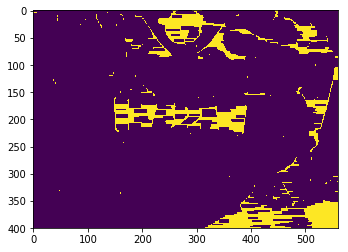

In [6]:
import cv2
import glob
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

def preprocess(img):
	#cv2.imshow("Input",img)
	imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
	gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)
	img = cv2.resize(gray, (560,400), interpolation = cv2.INTER_CUBIC)
	sobelx = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=3)
	#cv2.imshow("Sobel",sobelx)
	plt.imshow(sobelx)
	#cv2.waitKey(0)
	ret2,threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	#cv2.imshow("Threshold",threshold_img)
	#cv2.waitKey(0)
	print('ok we processed one first step')
	return threshold_img

def cleanPlate(plate):
	print ("CLEANING PLATE. . .")
	gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
	#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
	#thresh= cv2.dilate(gray, kernel, iterations=1)

	_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
	im1,contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

	if contours:
		areas = [cv2.contourArea(c) for c in contours]
		max_index = np.argmax(areas)

		max_cnt = contours[max_index]
		max_cntArea = areas[max_index]
		x,y,w,h = cv2.boundingRect(max_cnt)

		if not ratioCheck(max_cntArea,w,h):
			return plate,None

		cleaned_final = thresh[y:y+h, x:x+w]
		#cv2.imshow("Function Test",cleaned_final)
		return cleaned_final,[x,y,w,h]

	else:
		return plate,None


def extract_contours(threshold_img):
	element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
	morph_img_threshold = threshold_img.copy()
	cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
	#cv2.imshow("Morphed",morph_img_threshold)
	#cv2.waitKey(0)

	im2,contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
	#print("contours",contours)
	plt.imshow(im2)
	return contours


def ratioCheck(area, width, height):
	ratio = float(width) / float(height)
	if ratio < 1:
		ratio = 1 / ratio

	aspect = 4.7272
	min = 15*aspect*15  # minimum area
	max = 125*aspect*125  # maximum area

	rmin = 3
	rmax = 9

	if (area < min or area > max) or (ratio < rmin or ratio > rmax):
		print('ratiocheck is false')
		return False
#		print('ratiocheck is false')
	return True

def isMaxWhite(plate):
	avg = np.mean(plate)
	print("we are in ismaxwhite and avg is",avg)
	if(avg>=115):
		return True
	else:
 		print("ismaxwhite is returning false")
 		return False

def validateRotationAndRatio(rect):
	(x, y), (width, height), rect_angle = rect
	print('width and height  is',width,height)
	if(width>height):
		angle = -rect_angle
#		print('angle is',angle)
	else:
		angle = 90 + rect_angle
#		print('angle is 90+',angle)
	if angle>15:
#		print('angle returning false')
	 	return False

	if (height == 0) or (width == 0):
#		print(" height and width are 0, returning false")
		return False

	area = height*width
	print('area is ', area)
	if not ratioCheck(area,width,height):
		print("so validation is returning false")
		return False
#
	else:
		print("so validation is returning true")
		return True
#		print("so validation is returning true")


def cleanAndRead(img,contours):
	#count=0
	for i,cnt in enumerate(contours):
#	for i,cnt in range[5,]:
		min_rect = cv2.minAreaRect(cnt)
		print('the value of i is rect', i)
		if validateRotationAndRatio(min_rect):

			x,y,w,h = cv2.boundingRect(cnt)
			plate_img = img[y:y+h,x:x+w]
			#plt.imshow(plate_img)
			#cv2.waitKey(0)
			print("we crossed ratiocheck and validation ", x, y , w, h)

			if(isMaxWhite(plate_img)):
				#count+=1
				print("we crossed ismaxwhite, lets call cleanplate")
				clean_plate, rect = cleanPlate(plate_img)

				if rect:
					x1,y1,w1,h1 = rect
					x,y,w,h = x+x1,y+y1,w1,h1
#					cv2.imshow("Cleaned Plate",clean_plate)
					#cv2.waitKey(0)
					print("we are here after cleaning and now we are detectinh")
#					plate_im = Image.fromarray(clean_plate)
#					print("we readi plate_in value", plate_im)
#					text = tess.image_to_string(plate_im, lang='eng')
#					text = tess.image_to_string(Image.open(clean_plate), lang='eng')
#					print ("Detected Text : ",text)
					img = cv2.rectangle(clean_plate,(x,y),(x+w,y+h),(0,255,0),2)
#					img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
					#plt.imshow(img)
					#cv2.waitKey(0)
        
#					print(pytesseract.image_to_string(img))
	#print "No. of final cont : " , count



#if __name__ == '__main__':
for img in glob.glob("./carimages/y/*.jpg"):
	print ("DETECTING PLATE . . .")
#t = time.time()
	#img = cv2.imread("testData/Final.JPG")
	plt.figure()
	img = cv2.imread(img)
	#print('here')
	threshold_img = preprocess(img)
	contours= extract_contours(threshold_img)

	#if len(contours)!=0:
		#print len(contours) #Test
		# cv2.drawContours(img, contours, -1, (0,255,0), 1)
		# cv2.imshow("Contours",img)
		# cv2.waitKey(0)


	cleanAndRead(img,contours)
#print('Time taken: %d ms'%((time.time()-t1)*1000))